In [1]:
import pandas as pd
import numpy as np
#dev
import importlib as imp
import functions
from functions import *
import functions_data_prep
from functions_data_prep import *
import functions_data_viz
from functions_data_viz import *


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
BASE_PATH = "datasets/EATD-Corpus/"
# BASE_PATH_CUTS = "datasets/EATD-Corpus/cuts/"
# files = os.listdir(BASE_PATH+"/cuts")

### Read in pandas

In [3]:
df = pd.read_csv(BASE_PATH + "depression_categories_EATD-Corpus.csv")

In [4]:
df.head(3)

,folder,SDS_raw,SDS_index,depression,type,Participant_ID,PHQ8_Binary,PHQ8_multiclass,dataset,PHQ8_Score
0,t_1,37.0,46.25,normal,training,t_1,0,0,train,-1
1,t_10,30.0,37.50,normal,training,t_10,0,0,train,-1
2,t_101,42.0,52.50,mild,training,t_101,1,1,train,-1


### Gender ?

In [225]:
df = df[df["Gender"] == 0]

In [35]:
feature_path = BASE_PATH + "t_1_mfcc_.npy"

organized_features = load_and_organize_features(feature_path)

In [36]:
organized_features

[{'mfcc_mean': array([-4.06277618e+02,  1.40856995e+02, -3.39708138e+01,  3.39630470e+01,
         -1.24310665e+01, -9.85594463e+00, -1.22471590e+01, -7.16667223e+00,
         -5.44445992e+00, -1.55602288e+00, -3.54184699e+00, -2.08670044e+00,
          5.99869728e+00, -3.77197218e+00,  1.03793268e+01,  2.28038859e+00,
         -1.48843908e+00, -1.24123228e+00, -9.63190913e-01, -1.69677138e+00,
         -3.15108013e+00,  2.53900504e+00, -2.28286672e+00,  3.22276688e+00,
         -1.41754699e+00,  1.99813291e-01, -6.38331711e-01, -9.68417883e-01,
          1.65042329e+00, -2.75209951e+00,  2.42822361e+00,  1.06525138e-01,
          1.97596896e+00, -4.77818698e-01,  1.05040038e+00,  1.28543699e+00,
         -1.26454210e+00,  1.52142441e+00, -1.09673810e+00,  1.53693259e+00]),
  'mfcc_std': array([52.19888687, 34.62416077, 24.17987442, 24.21759224, 24.11869812,
         24.01966095, 17.25518227, 16.92097473, 11.24372005,  9.90390301,
         12.30278206, 10.23972988,  8.73317909,  9.1705

--------------

### SAve AVG stuff

In [37]:
imp.reload(functions_data_prep)
from functions_data_prep import *

for _, row in df.iterrows():
    patient_id =  row['Participant_ID']
    try:
        feature_path = BASE_PATH+f"{str(patient_id)}_mfcc_.npy"
        organized_features = load_and_organize_features(feature_path)

        create_feature_summary_df(organized_features).to_csv(f"{BASE_PATH}_AVG_MIN_MAX_{patient_id}.csv")
    except Exception as e:
        print(f"Error with patient {patient_id}, {e}")
        continue

Error with patient v_99, too many indices for array: array is 1-dimensional, but 2 were indexed


In [36]:
patient_id = 302

feature_path = BASE_PATH_CUTS+f"best_paper_features_only_mfcc_{str(patient_id)}.npy"
organized_features = load_and_organize_features(feature_path)
test_df = create_feature_summary_df(organized_features)

------------------

### Load patient's features

In [5]:
def load_patient_features(patient_ids, base_path):
    """
    Load feature DataFrames for multiple patients and combine them.
    """
    all_patient_dfs = []
    patient_ids = patient_ids['Participant_ID']
    
    for patient_id in patient_ids:
        try:
            # Load the CSV file for this patient
            file_path = f"{base_path}_AVG_MIN_MAX_{patient_id}.csv"
            patient_df = pd.read_csv(file_path, index_col=0)
            
            # Add patient ID column
            patient_df['patient_id'] = patient_id
            
            all_patient_dfs.append(patient_df)
        except Exception as e:
            print(f"Error loading patient {patient_id}: {e}")
            continue
    
    # Combine all patient DataFrames
    if all_patient_dfs:
        combined_df = pd.concat(all_patient_dfs, ignore_index=True)
        return combined_df
    return None

def add_PHQ8_scores(features_df, original_df):
    """
    Add PHQ8 scores to the features DataFrame from the original DataFrame.
    
    Args:
        features_df: DataFrame containing the features (with patient_id column)
        original_df: Original DataFrame containing PHQ8 scores and Participant_ID
    
    Returns:
        DataFrame with added PHQ8 columns
    """
    # Create mapping dictionary from original DataFrame
    phq8_mapping = original_df.set_index('Participant_ID')[['PHQ8_Binary', 'PHQ8_Score', 'PHQ8_multiclass']]
    #phq8_mapping = original_df.set_index('Participant_ID')[['PHQ8_Binary', 'PHQ8_multiclass']]
    
    # Map the scores using patient_id
    features_df = features_df.copy()
    features_df['PHQ8_Binary'] = features_df['patient_id'].map(phq8_mapping['PHQ8_Binary'])
    features_df['PHQ8_Score'] = features_df['patient_id'].map(phq8_mapping['PHQ8_Score'])
    features_df['PHQ8_multiclass'] = features_df['patient_id'].map(phq8_mapping['PHQ8_multiclass'])
    
    return features_df



df_train_pre = df[df["dataset"] == "train"]
df_dev_pre = df[df["dataset"] == "dev"]
df_train = load_patient_features(df_train_pre, BASE_PATH)
df_dev = load_patient_features(df_dev_pre, BASE_PATH)

df_train_2 = add_PHQ8_scores(df_train, df)
df_dev_2 = add_PHQ8_scores(df_dev, df)

Error loading patient v_99: [Errno 2] No such file or directory: 'datasets/EATD-Corpus/_AVG_MIN_MAX_v_99.csv'


In [6]:
# keep only patient id-s in both dataset what can be found in the df
df_train_2.head(5)

,mfcc_mean_0_min,mfcc_mean_0_max,mfcc_mean_0_avg,mfcc_std_0_min,mfcc_std_0_max,mfcc_std_0_avg,mfcc_mean_1_min,mfcc_mean_1_max,mfcc_mean_1_avg,mfcc_std_1_min,...,energy_min,energy_max,energy_avg,speech_rate_min,speech_rate_max,speech_rate_avg,patient_id,PHQ8_Binary,PHQ8_Score,PHQ8_multiclass
0,-406.277618,-383.986847,-398.333018,47.529854,57.467113,52.398618,140.856995,152.152985,146.470642,33.675240,...,81.628563,151.960526,105.780866,3.561662,4.154077,3.925109,t_1,0,-1,0
1,-387.064880,-361.700653,-376.870778,84.700691,103.523453,93.209534,144.212021,162.172913,155.876765,60.863853,...,238.241043,424.037567,339.933446,3.288882,3.556344,3.425794,t_10,0,-1,0
2,-391.643219,-341.573578,-374.148061,72.094917,84.930038,79.747164,109.533623,121.584999,115.262520,50.415821,...,134.434113,583.712708,394.463094,3.545151,5.351130,4.347795,t_101,1,-1,1
3,-480.533936,-449.679138,-461.114878,65.469666,75.365013,70.393077,104.400658,128.931122,120.456571,44.250900,...,115.025169,193.752441,147.326958,3.808980,4.043646,3.924441,t_102,1,-1,3
4,-345.602386,-282.059692,-308.126495,39.442436,75.089821,58.383222,116.148407,134.597107,124.606644,49.660358,...,240.070343,1528.925537,680.201935,5.087028,6.483499,5.639352,t_103,1,-1,1


### BINARY OR MULTICLASS?

In [7]:
# List of columns to exclude from features
exclude_columns = ['patient_id', 'PHQ8_Binary', 'PHQ8_Score', 'PHQ8_multiclass']

# Extract features (X) by dropping the non-feature columns
X_train = df_train_2.drop(columns=exclude_columns)
X_dev = df_dev_2.drop(columns=exclude_columns)

MODE = "Binary"

if MODE == "Binary":
    y_train = df_train_2["PHQ8_Binary"].values
    y_dev = df_dev_2["PHQ8_Binary"].values
elif MODE == "Multiclass":
    y_train = df_train_2["PHQ8_multiclass"].values
    y_dev = df_dev_2["PHQ8_multiclass"].values

# Feature importance

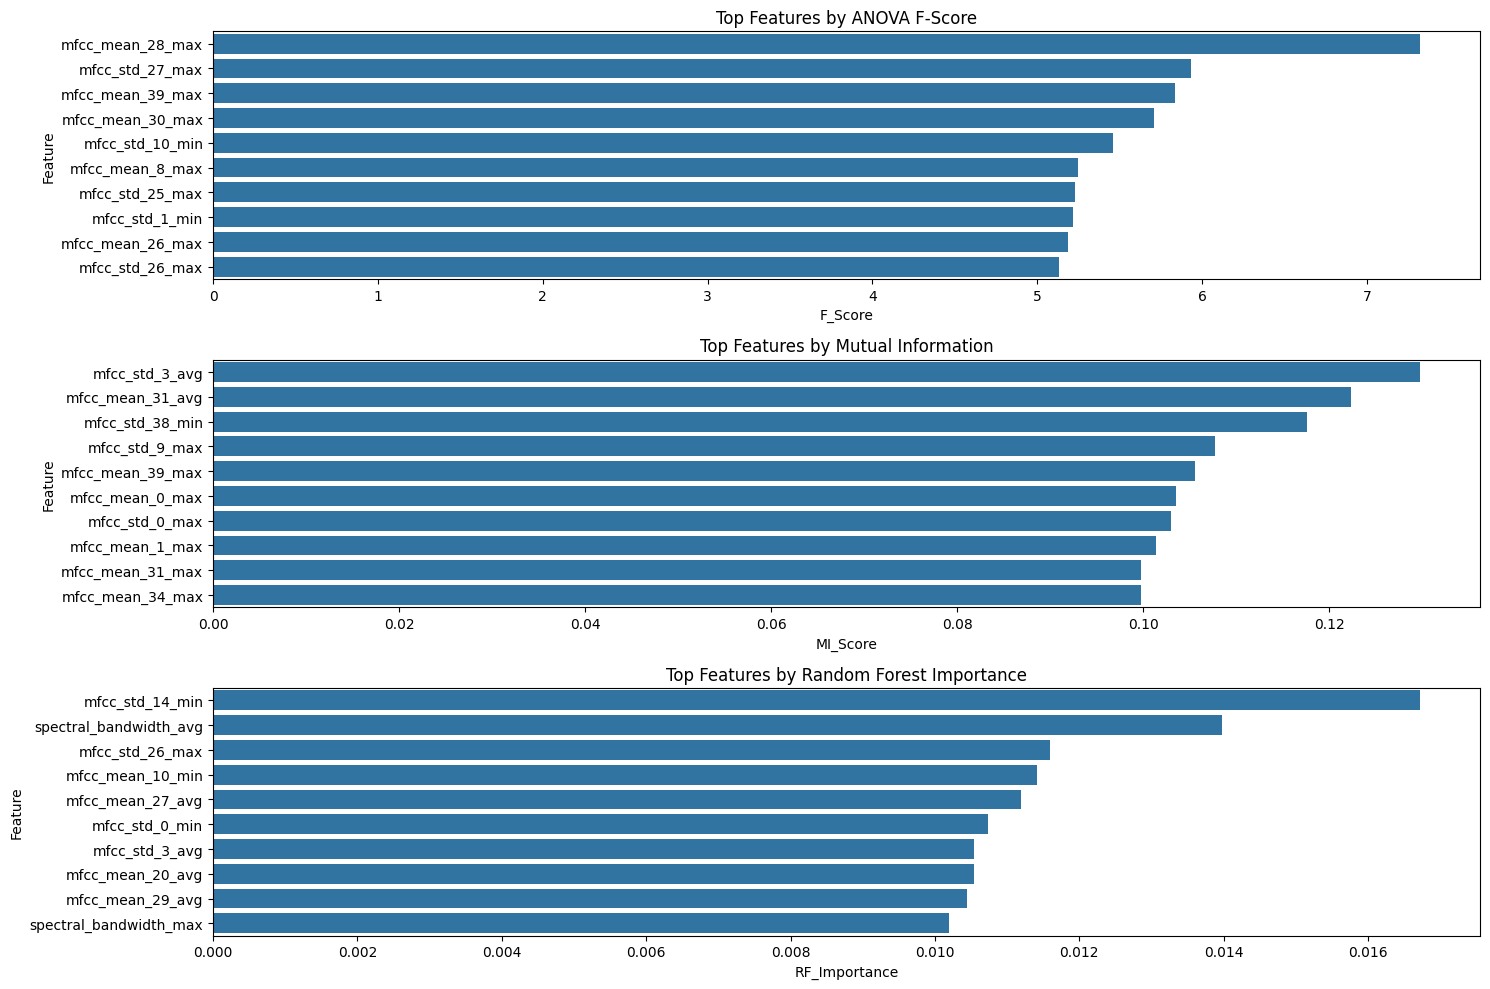


Top 20 Features (by average rank across methods):
              Feature     Score
23     mfcc_std_3_avg  0.129728
188  mfcc_mean_31_avg  0.122376
231   mfcc_std_38_min  0.117642
58     mfcc_std_9_max  0.107716
235  mfcc_mean_39_max  0.105538
1     mfcc_mean_0_max  0.103553
4      mfcc_std_0_max  0.103043
7     mfcc_mean_1_max  0.101359
187  mfcc_mean_31_max  0.099805
205  mfcc_mean_34_max  0.099786

Classification Report with Selected Features:
              precision    recall  f1-score   support

           0       0.72      0.65      0.69        52
           1       0.42      0.50      0.46        26

    accuracy                           0.60        78
   macro avg       0.57      0.58      0.57        78
weighted avg       0.62      0.60      0.61        78

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        27

    accuracy                           1.00        83
   ma

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



def analyze_feature_importance(X_train, y_train, X_dev, top_features_choose="ANOVA"):
    """
    Analyze feature importance using multiple methods
    """
    n_top_features=10
    results = {}
    
    # 1. ANOVA F-value for binary/multiclass classification
    f_selector = SelectKBest(f_classif, k='all')
    f_selector.fit(X_train, y_train)
    f_scores = pd.DataFrame({
        'Feature': X_train.columns,
        'F_Score': f_selector.scores_
    }).sort_values('F_Score', ascending=False)
    
    # 2. Mutual Information
    mi_selector = SelectKBest(mutual_info_classif, k='all')
    mi_selector.fit(X_train, y_train)
    mi_scores = pd.DataFrame({
        'Feature': X_train.columns,
        'MI_Score': mi_selector.scores_
    }).sort_values('MI_Score', ascending=False)
    
    # 3. Random Forest Feature Importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_scores = pd.DataFrame({
        'Feature': X_train.columns,
        'RF_Importance': rf.feature_importances_
    }).sort_values('RF_Importance', ascending=False)
    
    # Store results
    results['f_scores'] = f_scores
    results['mi_scores'] = mi_scores
    results['rf_scores'] = rf_scores
    
    # Plot top features from each method
    plt.figure(figsize=(15, 10))
    
    # F-scores
    plt.subplot(3, 1, 1)
    sns.barplot(data=f_scores.head(n_top_features), x='F_Score', y='Feature')
    plt.title('Top Features by ANOVA F-Score')
    
    # Mutual Information
    plt.subplot(3, 1, 2)
    sns.barplot(data=mi_scores.head(n_top_features), x='MI_Score', y='Feature')
    plt.title('Top Features by Mutual Information')
    
    # Random Forest
    plt.subplot(3, 1, 3)
    sns.barplot(data=rf_scores.head(n_top_features), x='RF_Importance', y='Feature')
    plt.title('Top Features by Random Forest Importance')
    
    plt.tight_layout()
    plt.show()
    
    # Find common important features across methods


    # Find common important features across methods based on chosen method
    if top_features_choose == "RF":
        top_features = pd.DataFrame({
            'Feature': X_train.columns,
            'F_Score_Rank': f_scores['Feature'].rank(ascending=True),
            'MI_Score_Rank': mi_scores['Feature'].rank(ascending=True),
            'RF_Rank': rf_scores['Feature'].rank(ascending=True)
        })
        top_features['Average_Rank'] = top_features[['F_Score_Rank', 'MI_Score_Rank', 'RF_Rank']].mean(axis=1)
        top_features = top_features.sort_values('Average_Rank', ascending=True)
        
    elif top_features_choose == "ANOVA":
        top_features = pd.DataFrame({
            'Feature': f_scores['Feature'],
            'Score': f_scores['F_Score']
        })
        top_features = top_features.sort_values('Score', ascending=False)

    elif top_features_choose == "MI":
        top_features = pd.DataFrame({
            'Feature': mi_scores['Feature'],
            'Score': mi_scores['MI_Score']
        })
        top_features = top_features.sort_values('Score', ascending=False)

    
    #top_features['Average_Rank'] = top_features[['F_Score_Rank', 'MI_Score_Rank', 'RF_Rank']].mean(axis=1)
    #top_features = top_features.sort_values('Average_Rank', ascending=True)
    
    print("\nTop 20 Features (by average rank across methods):")
    print(top_features.head(10))
    
    return results, top_features

# Use the function
results, top_features = analyze_feature_importance(X_train, y_train, X_dev, top_features_choose="ANOVA")

# Create a dataset with only the top features
n_features_to_use = 9  # You can adjust this number
top_feature_names = top_features.head(n_features_to_use)['Feature'].values

X_train_selected = X_train[top_feature_names]
X_dev_selected = X_dev[top_feature_names]

# Train and evaluate model with selected features
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_dev_selected)
x_pred = clf.predict(X_train_selected)

print("\nClassification Report with Selected Features:")
print(classification_report(y_dev, y_pred))
print(classification_report(y_train, x_pred))

### single guy

Training Accuracy: 0.963855421686747
Development Accuracy: 0.6538461538461539

Classification Report on Development Set:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77        52
           1       0.47      0.27      0.34        26

    accuracy                           0.65        78
   macro avg       0.58      0.56      0.55        78
weighted avg       0.62      0.65      0.62        78


Classification Report on Training Set:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        56
           1       1.00      0.89      0.94        27

    accuracy                           0.96        83
   macro avg       0.97      0.94      0.96        83
weighted avg       0.97      0.96      0.96        83



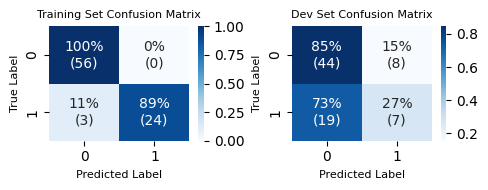

Training Set Metrics:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        56
           1       1.00      0.89      0.94        27

    accuracy                           0.96        83
   macro avg       0.97      0.94      0.96        83
weighted avg       0.97      0.96      0.96        83


Dev Set Metrics:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77        52
           1       0.47      0.27      0.34        26

    accuracy                           0.65        78
   macro avg       0.58      0.56      0.55        78
weighted avg       0.62      0.65      0.62        78



In [37]:
import functions_data_viz
from functions_data_viz import *
imp.reload(functions_data_viz)
from functions_data_viz import *

f = 27
max_depth  = 6

top_feature_names = top_features['Feature'].head(f).values

# Select data with top 'f' features
X_train_selected = X_train[top_feature_names]
X_dev_selected = X_dev[top_feature_names]

# Train and evaluate model with selected features
clf = DecisionTreeClassifier(random_state=42, max_depth=max_depth)
clf.fit(X_train_selected, y_train)
y_pred_dev = clf.predict(X_dev_selected)
y_pred_train = clf.predict(X_train_selected)

# Calculate and print accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
dev_accuracy = accuracy_score(y_dev, y_pred_dev)

print(f"Training Accuracy: {train_accuracy}")
print(f"Development Accuracy: {dev_accuracy}")

# Optionally: Output the classification report for each iteration
print("\nClassification Report on Development Set:")
print(classification_report(y_dev, y_pred_dev))
print("\nClassification Report on Training Set:")
print(classification_report(y_train, y_pred_train))
# plot_confusion_matrices_binary(clf, X_train_selected, y_train, X_dev_selected, y_dev)
plot_confusion_matrices_rate(clf, X_train_selected, y_train, X_dev_selected, y_dev, show_plot="all", save=True)


#### Find the best model

In [74]:
from sklearn.metrics import classification_report, accuracy_score

# Placeholder for accuracy tracking
accuracies = []

for f in range(1, 31):  # Adjust upper range as needed
    print(f"\nNumber of features: {f}")
    # Select top 'f' features
    top_feature_names = top_features['Feature'].head(f).values

    # Select data with top 'f' features
    X_train_selected = X_train[top_feature_names]
    X_dev_selected = X_dev[top_feature_names]

    # Train and evaluate model with selected features
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train_selected, y_train)
    y_pred_dev = clf.predict(X_dev_selected)
    y_pred_train = clf.predict(X_train_selected)

    # Calculate and print accuracy
    train_accuracy = accuracy_score(y_train, y_pred_train)
    dev_accuracy = accuracy_score(y_dev, y_pred_dev)
    accuracies.append(dev_accuracy)

    print(f"Training Accuracy: {train_accuracy}")
    print(f"Development Accuracy: {dev_accuracy}")

    # Optionally: Output the classification report for each iteration
    #print("\nClassification Report on Development Set:")
    #print(classification_report(y_dev, y_pred_dev))

# Identify the number of features with the highest development accuracy
best_num_features = np.argmax(accuracies) + 1  # +1 because index starts at 0
best_accuracy = accuracies[best_num_features - 1]

print(f"Best number of features: {best_num_features} with an accuracy of {best_accuracy}")

# Train final model with best number of features
final_top_features = top_features['Feature'].head(best_num_features).values
X_train_final = X_train[final_top_features]
X_dev_final = X_dev[final_top_features]

final_clf = DecisionTreeClassifier(random_state=42)
final_clf.fit(X_train_final, y_train)
# You can save this model, or extract more insights or plots as needed.


Number of features: 1
Training Accuracy: 1.0
Development Accuracy: 0.5

Number of features: 2
Training Accuracy: 1.0
Development Accuracy: 0.6538461538461539

Number of features: 3
Training Accuracy: 1.0
Development Accuracy: 0.6025641025641025

Number of features: 4
Training Accuracy: 1.0
Development Accuracy: 0.48717948717948717

Number of features: 5
Training Accuracy: 1.0
Development Accuracy: 0.5512820512820513

Number of features: 6
Training Accuracy: 1.0
Development Accuracy: 0.6153846153846154

Number of features: 7
Training Accuracy: 1.0
Development Accuracy: 0.5256410256410257

Number of features: 8
Training Accuracy: 1.0
Development Accuracy: 0.4358974358974359

Number of features: 9
Training Accuracy: 1.0
Development Accuracy: 0.5641025641025641

Number of features: 10
Training Accuracy: 1.0
Development Accuracy: 0.5897435897435898

Number of features: 11
Training Accuracy: 1.0
Development Accuracy: 0.5128205128205128

Number of features: 12
Training Accuracy: 1.0
Developm

DecisionTreeClassifier(random_state=42)

In [36]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Placeholder for metrics tracking
best_metrics = {
    'f1_score': 0,
    'accuracy': 0,
    'best_features': 0
}

for f in range(1, 31):  # Adjust upper range as needed
    print(f"\nNumber of features: {f}")
    # Select top 'f' features
    top_feature_names = top_features['Feature'].head(f).values

    # Select data with top 'f' features
    X_train_selected = X_train[top_feature_names]
    X_dev_selected = X_dev[top_feature_names]

    # Train and evaluate model with selected features
    DEPTH = range(1, 20)
    for depth in DEPTH:
        clf = DecisionTreeClassifier(random_state=42, max_depth=depth)
        clf.fit(X_train_selected, y_train)
        y_pred_dev = clf.predict(X_dev_selected)

        # Obtain classification metrics
        report = classification_report(y_dev, y_pred_dev, output_dict=True)
        f1 = report['weighted avg']['f1-score']
        acc = accuracy_score(y_dev, y_pred_dev)
        
        # Optionally calculate AUC-ROC for binary classification
        if len(np.unique(y_dev)) == 2:
            roc_auc = roc_auc_score(y_dev, clf.predict_proba(X_dev_selected)[:, 1])
        else:
            roc_auc = None

        # Update best metrics based on F1 score or another chosen metric
        if f1 > best_metrics['f1_score']:
            best_metrics['f1_score'] = f1
            best_metrics['accuracy'] = acc
            best_metrics['best_features'] = f
            best_metrics['roc_auc'] = roc_auc
            best_depth = depth

        print(f"F1-score: {f1}, Accuracy: {acc}, Depth: {depth}")

print("\nBest model performance:")
print(f"Best F1-score: {best_metrics['f1_score']} at {best_metrics['best_features']} features, depth: {best_depth}")
print(f"Best Accuracy: {best_metrics['accuracy']}")
if roc_auc:
    print(f"Best ROC-AUC: {best_metrics['roc_auc']}")


Number of features: 1
F1-score: 0.5550595238095237, Accuracy: 0.6666666666666666, Depth: 1
F1-score: 0.5550595238095237, Accuracy: 0.6666666666666666, Depth: 2
F1-score: 0.5550595238095237, Accuracy: 0.6666666666666666, Depth: 3
F1-score: 0.5550595238095237, Accuracy: 0.6666666666666666, Depth: 4
F1-score: 0.5550595238095237, Accuracy: 0.6666666666666666, Depth: 5
F1-score: 0.5893817204301075, Accuracy: 0.6666666666666666, Depth: 6
F1-score: 0.5893817204301075, Accuracy: 0.6666666666666666, Depth: 7
F1-score: 0.5299145299145299, Accuracy: 0.5769230769230769, Depth: 8
F1-score: 0.5177697247123149, Accuracy: 0.5256410256410257, Depth: 9
F1-score: 0.5037593984962406, Accuracy: 0.5384615384615384, Depth: 10
F1-score: 0.47687687687687697, Accuracy: 0.5, Depth: 11
F1-score: 0.5037593984962406, Accuracy: 0.5384615384615384, Depth: 12
F1-score: 0.47687687687687697, Accuracy: 0.5, Depth: 13
F1-score: 0.47687687687687697, Accuracy: 0.5, Depth: 14
F1-score: 0.47687687687687697, Accuracy: 0.5, De